# Udacity. Deep Reingorcement Learning : Continuous Control
### Markus Buchholz

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## BRAIN

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## MODEL

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=200, fc2_units=150):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## AGENT AND CRITIC

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

eps_star t= 1.0
eps_end = 0.01
eps_decay = 1e-6


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise((num_agents,action_size), random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(state.shape[0]):
            self.memory.add(state[i, :], action[i], reward[i], next_state[i, :], done[i])
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)        
        
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()    
        return np.clip(action, -1, 1)        
        
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## EXAMINE THE STATE AND ACTION SPACES

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## RANDOM SAMPLES

In [7]:
"""
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations            # get the current state
score = 0                                          # initialize the score
#env.viewer = None
#env.render()
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

"""

'\nenv_info = env.reset(train_mode=False)[brain_name] # reset the environment\nstate = env_info.vector_observations            # get the current state\nscore = 0                                          # initialize the score\n#env.viewer = None\n#env.render()\nwhile True:\n    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n    env_info = env.step(actions)[brain_name]        # send the action to the environment\n    next_state = env_info.vector_observations[0]   # get the next state\n    reward = env_info.rewards[0]                   # get the reward\n    done = env_info.local_done[0]                  # see if episode has finished\n    score += reward                                # update the score\n    state = next_state                             # roll over the state to next time step\n    if done:                                       # exit loop if epi

## DDPG

In [8]:
num_agents = len(env_info.agents)
agents = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

In [9]:
def ddpg(n_episodes=500):
    """Deep Deterministic Policy Gradient.
    
    Args
        n_episodes (int): maximum number of training episodes
    Return:
        scores (average score)

    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        while True:
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            
            agents.step(state, action, rewards, next_state, dones)
            score += rewards                                # update the score
            state = next_state                             # roll over the state to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break
        scores_window.append(np.mean(score))       # save most recent score
        scores.append(np.mean(score))              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_agent.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
    return scores

In [10]:
scores = ddpg()

Episode 100	Average Score: 13.53
Episode 200	Average Score: 29.62
Episode 206	Average Score: 30.05
Environment solved in 106 episodes!	Average Score: 30.05
Episode 207	Average Score: 30.13
Environment solved in 107 episodes!	Average Score: 30.13
Episode 208	Average Score: 30.21
Environment solved in 108 episodes!	Average Score: 30.21
Episode 209	Average Score: 30.29
Environment solved in 109 episodes!	Average Score: 30.29
Episode 210	Average Score: 30.37
Environment solved in 110 episodes!	Average Score: 30.37
Episode 211	Average Score: 30.47
Environment solved in 111 episodes!	Average Score: 30.47
Episode 212	Average Score: 30.54
Environment solved in 112 episodes!	Average Score: 30.54
Episode 213	Average Score: 30.61
Environment solved in 113 episodes!	Average Score: 30.61
Episode 214	Average Score: 30.70
Environment solved in 114 episodes!	Average Score: 30.70
Episode 215	Average Score: 30.76
Environment solved in 115 episodes!	Average Score: 30.76
Episode 216	Average Score: 30.81
E

Episode 297	Average Score: 34.57
Environment solved in 197 episodes!	Average Score: 34.57
Episode 298	Average Score: 34.60
Environment solved in 198 episodes!	Average Score: 34.60
Episode 299	Average Score: 34.65
Environment solved in 199 episodes!	Average Score: 34.65
Episode 300	Average Score: 34.69

Environment solved in 200 episodes!	Average Score: 34.69
Episode 301	Average Score: 34.73
Environment solved in 201 episodes!	Average Score: 34.73
Episode 302	Average Score: 34.75
Environment solved in 202 episodes!	Average Score: 34.75
Episode 303	Average Score: 34.78
Environment solved in 203 episodes!	Average Score: 34.78
Episode 304	Average Score: 34.77
Environment solved in 204 episodes!	Average Score: 34.77
Episode 305	Average Score: 34.79
Environment solved in 205 episodes!	Average Score: 34.79
Episode 306	Average Score: 34.79
Environment solved in 206 episodes!	Average Score: 34.79
Episode 307	Average Score: 34.78
Environment solved in 207 episodes!	Average Score: 34.78
Episode 3

Episode 389	Average Score: 34.66
Environment solved in 289 episodes!	Average Score: 34.66
Episode 390	Average Score: 34.66
Environment solved in 290 episodes!	Average Score: 34.66
Episode 391	Average Score: 34.68
Environment solved in 291 episodes!	Average Score: 34.68
Episode 392	Average Score: 34.70
Environment solved in 292 episodes!	Average Score: 34.70
Episode 393	Average Score: 34.71
Environment solved in 293 episodes!	Average Score: 34.71
Episode 394	Average Score: 34.72
Environment solved in 294 episodes!	Average Score: 34.72
Episode 395	Average Score: 34.72
Environment solved in 295 episodes!	Average Score: 34.72
Episode 396	Average Score: 34.72
Environment solved in 296 episodes!	Average Score: 34.72
Episode 397	Average Score: 34.75
Environment solved in 297 episodes!	Average Score: 34.75
Episode 398	Average Score: 34.73
Environment solved in 298 episodes!	Average Score: 34.73
Episode 399	Average Score: 34.67
Environment solved in 299 episodes!	Average Score: 34.67
Episode 40

Episode 481	Average Score: 35.44
Environment solved in 381 episodes!	Average Score: 35.44
Episode 482	Average Score: 35.45
Environment solved in 382 episodes!	Average Score: 35.45
Episode 483	Average Score: 35.45
Environment solved in 383 episodes!	Average Score: 35.45
Episode 484	Average Score: 35.44
Environment solved in 384 episodes!	Average Score: 35.44
Episode 485	Average Score: 35.42
Environment solved in 385 episodes!	Average Score: 35.42
Episode 486	Average Score: 35.40
Environment solved in 386 episodes!	Average Score: 35.40
Episode 487	Average Score: 35.39
Environment solved in 387 episodes!	Average Score: 35.39
Episode 488	Average Score: 35.38
Environment solved in 388 episodes!	Average Score: 35.38
Episode 489	Average Score: 35.38
Environment solved in 389 episodes!	Average Score: 35.38
Episode 490	Average Score: 35.39
Environment solved in 390 episodes!	Average Score: 35.39
Episode 491	Average Score: 35.38
Environment solved in 391 episodes!	Average Score: 35.38
Episode 49

## TRAIN DDPG AGENT

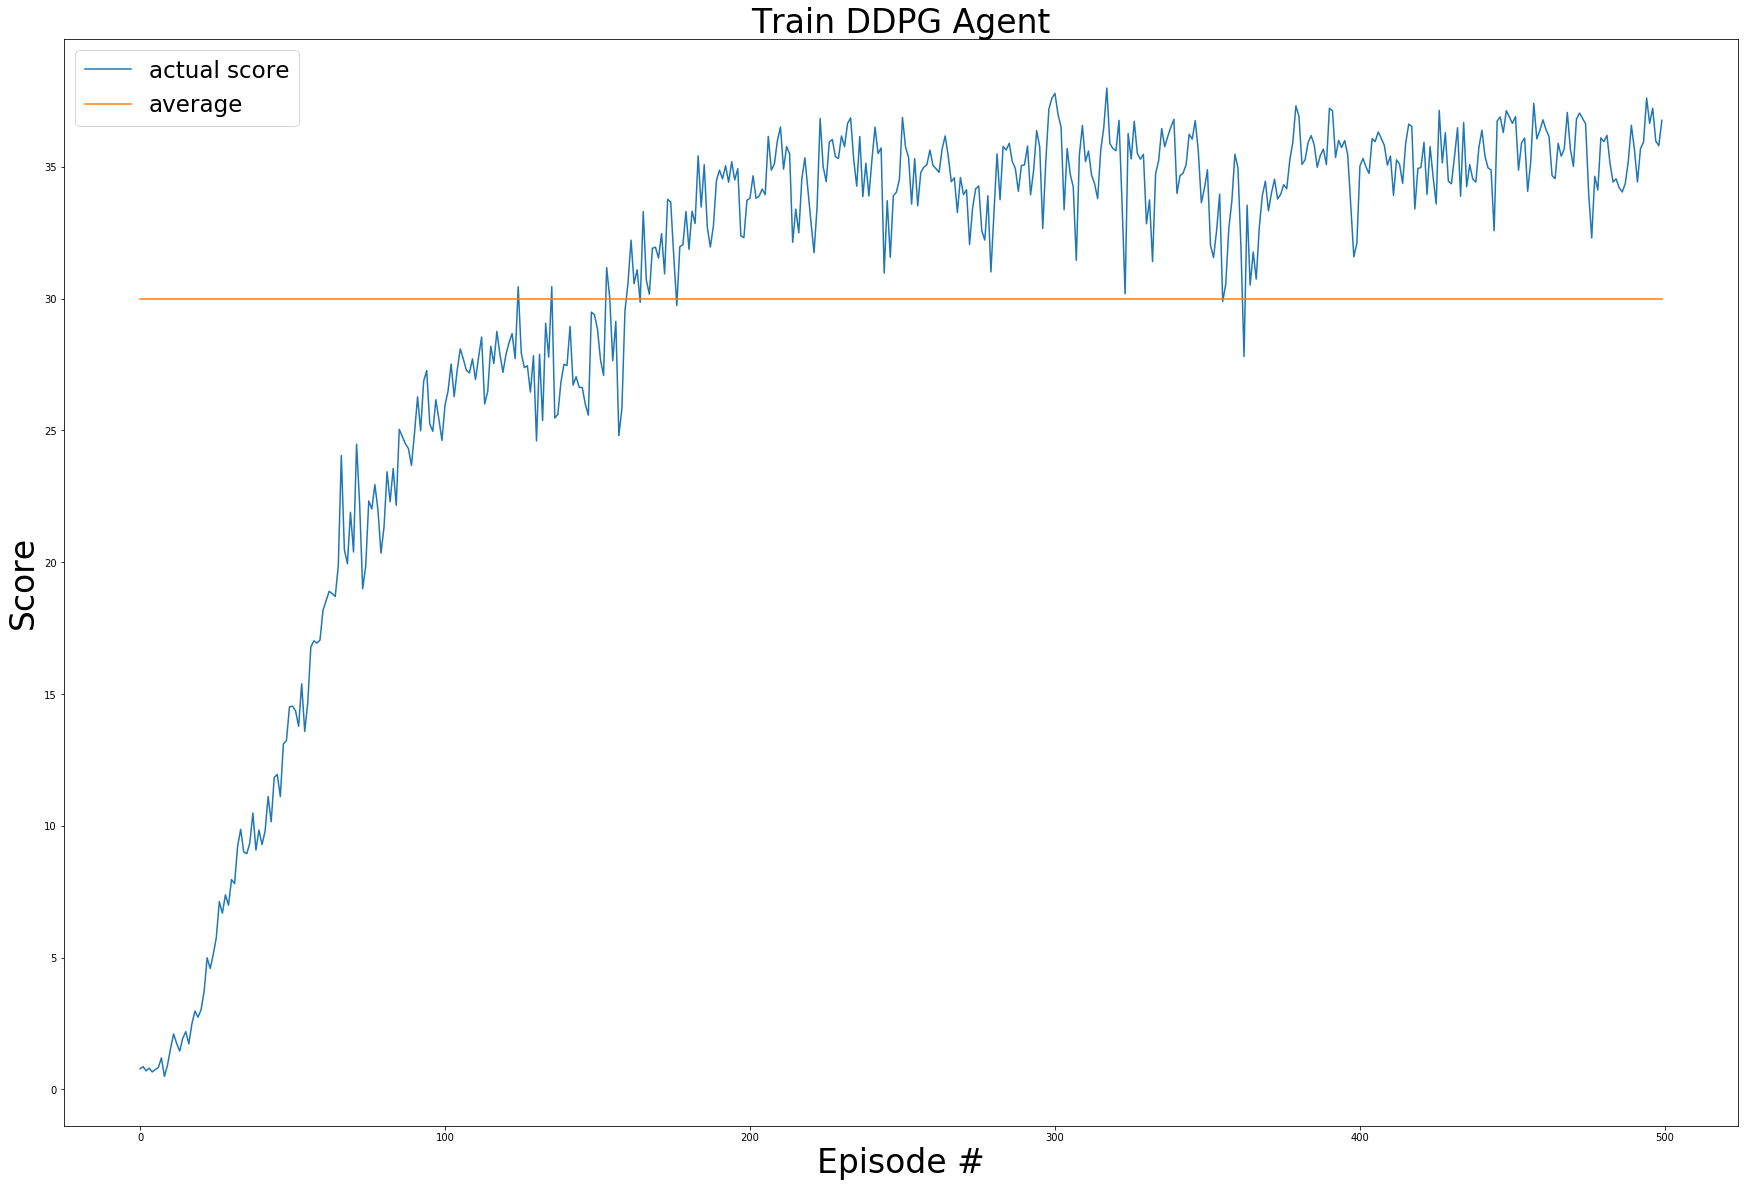

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt 

#def __init__(self, state_size, action_size, random_seed):
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
#scores = ddpg(agent)

# plot the scores
average_score = 30
success = [average_score] * len(scores)
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores,np.arange(len(scores)), success)
plt.ylabel('Score', fontsize = 33)
plt.xlabel('Episode #', fontsize = 33)
plt.title('Train DDPG Agent', fontsize = 33)
plt.gca().legend(('actual score','average'), fontsize = 23)
plt.show()


## WATCH THE AGENT IN ACTION

In [ ]:
# load the weights from file
#agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    
    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name] 
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        #print(reward)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            #print(reward)
            break

In [ ]:
filename_to_load = 'checkpoint.pth'
final_eps = 0.01

agent = Agent(state_size=37, action_size=4, seed=0)


agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))


num_episodes = 100
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=final_eps)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            print('Episode {}: {}'. format(i_episode, score))
            scores.append(score)
            break

print('All the scores{}'.format(scores))